## Lang-Kobayashi の steady-state solutions


### Equations

\begin{equation}
\left(\omega_{s}-\omega_{1}\right)\left(\omega_{s}-\omega_{2}\right)=\kappa^{2}\left(1+\alpha^{2}\right) \sin ^{2}\left[\omega_{s} \tau+\tan ^{-1} \alpha\right]
\end{equation}

\begin{equation}
\begin{aligned} N_{s 1, s 2}-N_{t h}=& \frac{2 \kappa^{2} \tau_{s} \sqrt{1+\alpha^{2}} \cos \left[\omega_{s} \tau\right] \sin \left[\omega_{s} \tau+\tan ^{-1} \alpha\right]}{\left(G_{N} \tau_{s}+\epsilon\right)\left(\omega_{s}-\omega_{2,1}\right)} +\frac{\epsilon N_{t h}(j-1)}{G_{N} \tau_{s}+\epsilon} \end{aligned}
\end{equation}



In [1]:
using NLsolve
using ForwardDiff
using LinearAlgebra
using Plots

┌ Info: Recompiling stale cache file /Users/yasu/.julia/compiled/v1.1/NLsolve/KFCNP.ji for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
└ @ Base loading.jl:1184


#### How to use NLsolve

In [2]:
function test_func!(F, x)
    F[1] = x[1]^2 - 1.0
    F[2] = x[2]^2 - 4.0
end

test_func! (generic function with 1 method)

In [3]:
initial_x = [10.0, 10.0]
sol = nlsolve(test_func!, initial_x, autodiff = :forward)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [10.0, 10.0]
 * Zero: [1.0, 2.0]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 8
 * Jacobian Calls (df/dx): 8

In [4]:
if converged(sol)
    println(sol.zero)
end

[1.0, 2.0]


#### Lang-Kobayashi

In [89]:
tau = 5.0 # ns
tau_s = 2.04 # ns
kappa = 31.06 # ns^(-1)
alpha = 3.0
j = 1.1
G_N = 840.0 # (10^(-8)m)^3 ns^(-1)
epsilon = 20.0 # (10^(-8)m)^3
N_th = 1.40 + (1.0/(840.0 + 0.001927)) # (10^(-8)m)^(-3)
f_1=29980000.0/153.7 # ns^(-1)
delta_f=2.0
omega_1 = 2.0 * pi *f_1
omega_2 = omega_1- 2.0*pi*delta_f
omega_1plus2 = omega_1 + omega_2

2.45112465561044e6

In [91]:
function f!(F, x)
    #F[1] = (x[1] - omega_1)*(x[1] - omega_2) - kappa^2 * (1.0 + alpha^2) * sin(x[1] * tau + atan(alpha))^2
    F[1] = x[1] * (x[1] - omega_1plus2) + (omega_1*omega_2) - kappa^2 * (1.0 + alpha^2) * sin(x[1] * tau + atan(alpha))^2
end

f! (generic function with 1 method)

In [92]:
x_init = 0.1
(x_init - omega_1)*(x_init - omega_2) - kappa^2 * (1.0 + alpha^2) * sin(x_init * tau + atan(alpha))^2

1.5020027648394668e12

In [122]:
x_init * (x_init - omega_1plus2) + (omega_1*omega_2) - kappa^2 * (1.0 + alpha^2) * sin(x_init * tau + atan(alpha))^2

1.502002764839467e12

In [93]:
F = zeros(1)

1-element Array{Float64,1}:
 0.0

In [94]:
f!(F, [0.0001])

1.5020030103653538e12

In [95]:
sol = nlsolve(f!, [-20.0], autodiff = :forward, method= :newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-20.0]
 * Zero: [1.22547e6]
 * Inf-norm of residuals: 0.000002
 * Iterations: 76
 * Convergence: true
   * |x - x'| < 0.0e+00: true
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 76
 * Jacobian Calls (df/dx): 76

In [96]:
sol.zero[1]

1.2254675548533e6

In [120]:
f_init = -20.0:0.01:20
omega_s = []
f_s = []
for i = 1:length(f_init)
    omega_temp = omega_1 + 2*pi*f_init[i]
    #omega_temp = BigFloat(omega_temp)
    sol = nlsolve(f!, [omega_temp], autodiff=:forward, method=:newton, iterations=10^4, ftol=1e-15)
    if converged(sol)
        append!(omega_s, sol.zero[1])
        append!(f_s, (sol.zero[1]-omega_1)/(2.0*pi))
    end
end

In [135]:
using Printf
@printf("%15.10f\n", omega_1)
@printf("%15.10f\n", omega_s[1])
@printf("%15.10f\n", (omega_1 - omega_s[1]))

1225568.6109905271
1225464.3781452114
 104.2328453157


In [124]:
function get_N(x)
    denominator1 = (G_N * tau_s + epsilon) * (x[1] - omega_2)
    denominator2 = (G_N * tau_s + epsilon)
    N1 = N_th + 2.0 * kappa^2 * tau_s * sqrt(1.0 + alpha^2) * cos(x[1] * tau) * sin(x[1] * tau + atan(alpha)) / denominator1 + epsilon * N_th * (j - 1) / denominator2
    
    denominator1 = (G_N * tau_s + epsilon) * (x[1] - omega_1)
    denominator2 = (G_N * tau_s + epsilon)
    N2 = N_th + 2.0 * kappa^2 * tau_s * sqrt(1.0 + alpha^2) * cos(x[1] * tau) * sin(x[1] * tau + atan(alpha)) / denominator1 + epsilon * N_th * (j - 1) / denominator2
    [N1, N2]
end

get_N (generic function with 2 methods)

In [133]:
argmin(abs.(omega_s .- omega_1))

1303

In [134]:
println(omega_1)
println(omega_s[1303])
println(omega_1 - omega_s[1303])

1.225568610990527e6
1.2255689691753567e6
-0.35818482958711684


In [125]:
N_1s = zeros(length(omega_s))
N_2s = zeros(length(omega_s))
for i = 1:length(omega_s)
    #omega_temp = omega_1 + 2.0*pi*f_s[i]
    d = get_N(omega_s[i])
    N_1s[i] = d[1]
    N_2s[i] = d[2]
end

In [126]:
N_1s

2824-element Array{Float64,1}:
 1.3316285818534708
 1.3822076163730133
 1.3514356740796705
 1.32459666564534  
 1.3985230040229875
 1.3444316502891867
 1.3246945989084677
 1.3317292304787525
 1.3810385334450157
 1.3260218287892656
 1.324801926609164 
 1.36969014777141  
 1.3251927151607523
 ⋮                 
 1.4694856539858552
 1.465821722765018 
 1.4706525036937304
 1.458788548551879 
 1.469361532058015 
 1.465821722765018 
 1.465821722765018 
 1.4617496286686928
 1.4711519434255098
 1.4669427924854184
 1.4637517481186026
 1.452499903031144 

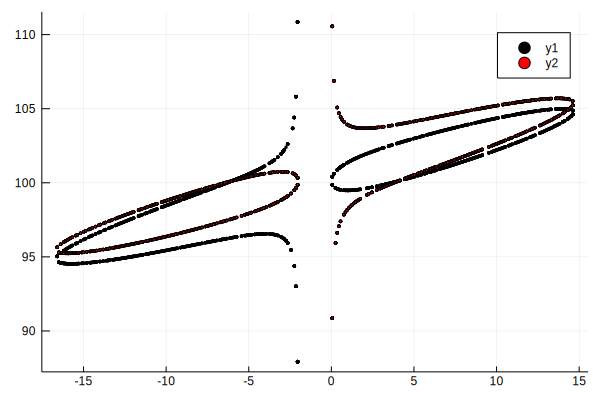

In [127]:
scatter(f_s, 100.0.*N_1s./N_th, color="black", markersize=1.0)
scatter!(f_s, 100.0.*N_2s./N_th, color="red", markersize=1.0)

In [128]:
F_zero = similar(omega_s)
d = zeros(Float64, 1)
for i = 1:length(omega_s)
    f!(d, omega_s[i])
    F_zero[i] = d[1]
end

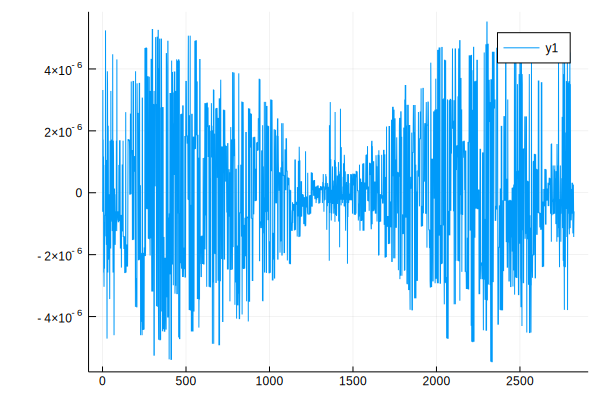

In [129]:
plot(F_zero)